**Deep Learning : *Autoencoders***



In this project, we will deal with _dimensionality reduction_ and learn how to develop a simple _Autoencoder_.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset seen in Recurrent Neural Networks & Transformer project.

In [1]:
# import the usual libriaries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

np.random.seed(42)

### Load Dataset
We load the CIFAR-10 dataset, using `tf.keras.datasets`. The dataset contains 60,000 training images and 10,000 testing images.
The images are originally in RGB format, but we will convert them to grayscale for convenience. The value of each pixel is between 0 and 255, and it represents a point of an image of size 32 x 32. We will normalize all values between 0 and 1, and we will flatten the 32x32 images into vectors of size 1024.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [2]:
cifar_10 = keras.datasets.cifar10
(X_train_full, _), (x_test, _) = cifar_10.load_data() # The dataset is already divede in test and training

X_train_full, x_test = np.mean(X_train_full, -1), np.mean(x_test, -1)

X_train_full = X_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

X_train_full = X_train_full.reshape((len(X_train_full), np.prod(X_train_full.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# We extract the first 10000 samples of the training set, to use them as the validation set
x_valid, x_train = X_train_full[:10000], X_train_full[10000:]

170508288/170498071 [==============================] - 2s 0us/step


## Exercise 1: Singular Value Decomposition

Similar to Principal component analysis (PCA), Singular Value Decomposition (SVD) is a standard linear dimensionality reduction method. They both linearly combine the features of the original high-dimensional dataset and project them into a lower-dimensional space, ideally retaing most of their intrinsic properties.

In this first part of the project, we will focus our attention on SVD decomposition and its performances. Given a matrix $X$, the SVD decomposes it into the product of two unitary matrices $V$ and $U$ and a rectangular diagonal matrix of singular values $S$:

$$ X=V \cdot S \cdot U^T.$$             

The SVD is already implemented in NumPy as `np.linalg.svd`. In our case, the $X$ matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features). However, notice that the $X$ matrix has a huge number of rows (we have 50,000 input samples) and only 1024 columns. If you are using the _Colab_ free plan, the quantity of available RAM may not be sufficient to compute the SVD of $X$. Therefore, to ease memory consumption and numerical stability, we resort to one property of the SVD and compute its equivalent version from the covariance matrix $C= X^T \cdot X$, that can be decomposed as:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix $U$ to compute the compressed version of our data, this trick turns out to be a quick and good solution.

In [3]:
def SVD(X, k):
    # Compute covariance matrix
    C = np.dot(X.T, X)
    # SVD decomposition
    U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
    # Limit the number columns of U to k
    U_k=U[:,:k]
    return U_k

Let's define the `ENCODING_DIM`, that will be the size of the compressed version of input data, and project the low-dimensional versions of the training set and the test set as well.

In [4]:
ENCODING_DIM = 120

U_k = SVD(x_train, ENCODING_DIM)

x_training_svd = np.dot(x_train, U_k)
x_test_svd = np.dot(x_test, U_k)

We now reconstruct back the original input and check how much information was lost due to the compression. We do so by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [5]:
x_training_reco = np.dot(x_training_svd, U_k.T)
x_test_reco = np.dot(x_test_svd, U_k.T)

In [6]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))

Training mse: 0.00372
Test mse: 0.00375


In [7]:
def plot_img(n, images_sets: list, title=""):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        for set_idx, images in enumerate(images_sets):
            ax = plt.subplot(len(images_sets), n, i + 1 + set_idx*n)
            plt.imshow(images[i].reshape(32, 32))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.suptitle(title)
    plt.show()

Let's see how well the input can be reconstructed by displaying a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images corresponds to input data, while the second one contains the reconstructions.

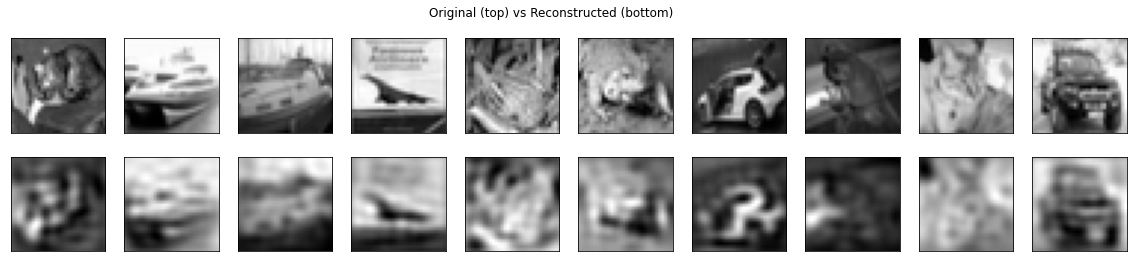

In [8]:
plot_img(10, [x_test, x_test_reco], title = "Original (top) vs Reconstructed (bottom)")

**What happens by varying the `ENCODING_DIM`? Try it out and discuss the results in this cell:** 

Encoding dimension: 32
Training MSE: 0.00980
Test MSE: 0.00984


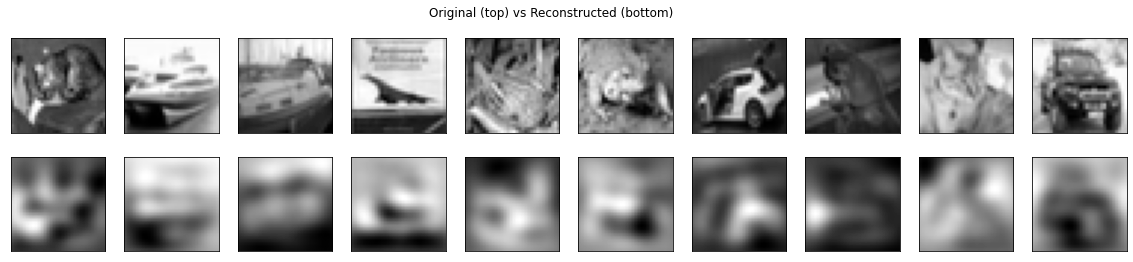

Encoding dimension: 64
Training MSE: 0.00628
Test MSE: 0.00631


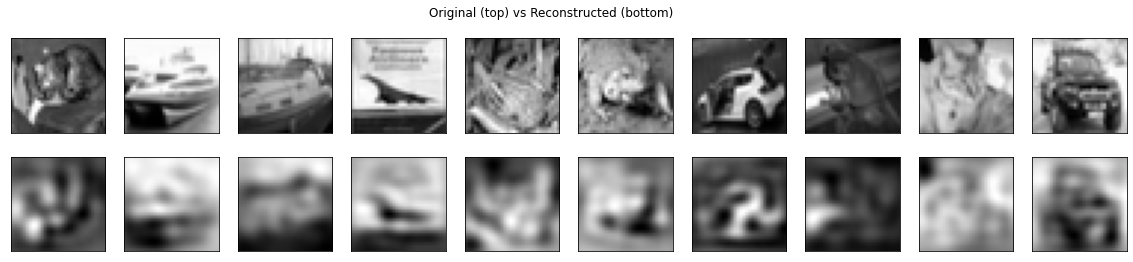

Encoding dimension: 256
Training MSE: 0.00150
Test MSE: 0.00153


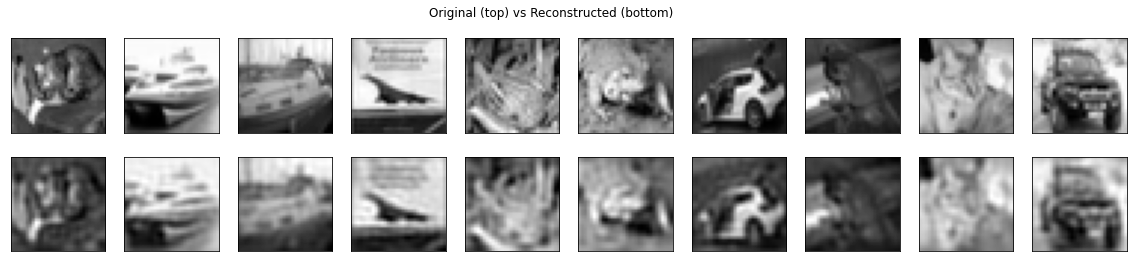

Encoding dimension: 512
Training MSE: 0.00037
Test MSE: 0.00038


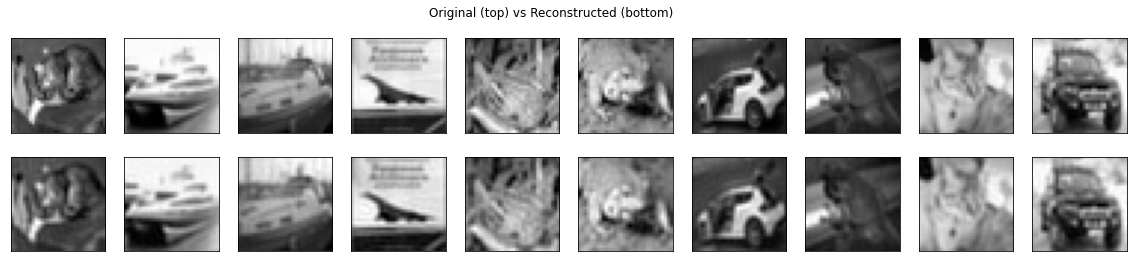

In [9]:
encoding_dimensions = [32, 64, 256, 512]

for encoding_dim in encoding_dimensions:
    U_k = SVD(x_train, encoding_dim)

    x_training_pca = np.dot(x_train, U_k)
    x_test_pca = np.dot(x_test, U_k)

    x_training_reco = np.dot(x_training_pca, U_k.T)
    x_test_reco = np.dot(x_test_pca, U_k.T)

    accuracy_train = ((x_train - x_training_reco)**2).mean()
    accuracy_test = ((x_test - x_test_reco)**2).mean()

    print('Encoding dimension: {}'.format(str(encoding_dim)))
    print("Training MSE: %.5f" % (accuracy_train))
    print("Test MSE: %.5f" % (accuracy_test))

    plot_img(10, [x_test, x_test_reco], title = "Original (top) vs Reconstructed (bottom)")

_Result:_

As can be seen from the above values, we can clearly see that the larger the encoding size, the better the image reconstruction. With a small encoding dimension, matrices are smaller than those with a larger encoding dimension. This means less time required for execution.

Using a small encoding dimension is that it keeps a narrow set of the most important information useful for reconstructing the images in the decompression phase. Indeed, we can see that the MSE (training and test) are bigger than those with a larger encoding dimension. The images are also more blurry with a small encoding dimension.

With a larger encoding dimension, the training and test MSE are smaller and the images are more defined and similar to the original ones. In this way, the larger encoding dimension allows to keep more important information useful for reconstructing the image

## Exercise 2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous projects(RNN and Transformer) when we used `Keras.Sequential()`, here we define the two parts of the model (encoder and decoder) separately and then we create the final model. 


In [10]:
ENCODING_DIM = 256
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

# ...the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='linear')(encoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

Print the model summary.

In [11]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [12]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
79/79 [==============================] - 4s 39ms/step - loss: 0.2050 - val_loss: 0.0361
Epoch 2/15
79/79 [==============================] - 3s 37ms/step - loss: 0.0326 - val_loss: 0.0236
Epoch 3/15
79/79 [==============================] - 3s 37ms/step - loss: 0.0336 - val_loss: 0.0214
Epoch 4/15
79/79 [==============================] - 3s 37ms/step - loss: 0.0182 - val_loss: 0.0145
Epoch 5/15
79/79 [==============================] - 3s 37ms/step - loss: 0.0133 - val_loss: 0.0126
Epoch 6/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0126 - val_loss: 0.0110
Epoch 7/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0103 - val_loss: 0.0099
Epoch 8/15
79/79 [==============================] - 3s 37ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 9/15
79/79 [==============================] - 5s 69ms/step - loss: 0.0086 - val_loss: 0.0083
Epoch 10/15
79/79 [==============================] - 5s 66ms/step - loss: 0.0084 - val_loss: 0.0077
Epoch 11/

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [13]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.grid()
  plt.title('loss')

313/313 - 1s - loss: 0.0056 - 758ms/epoch - 2ms/step
Test mse: 0.00558


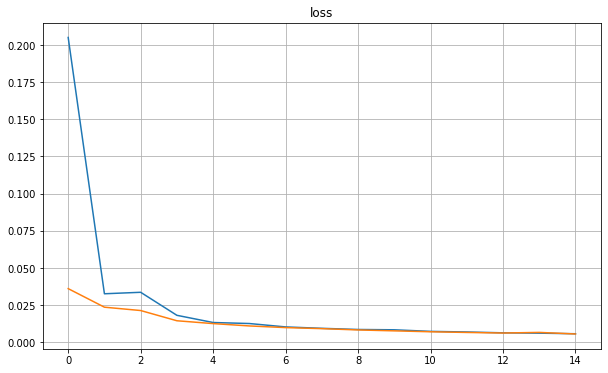

In [14]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

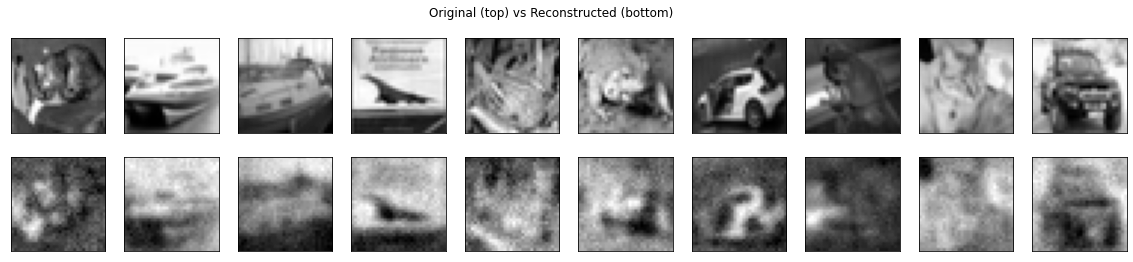

In [15]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

**I checked the results and compared them versus the results obtained with the SVD. Give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.** 


_Results (test MSE):_


- **SVD**: 0.00153
- **Shallow Linear Autoencoder**: 0.00558

Training an autoencoder with one dense encoder layer and one dense decoder layer and linear activation is essentially equivalent to performing SVD. However, the results are not very similar because the two approaches have the same goal to reach with different type. As the encoding dimension increases, the SVD nature goes to zero because of the encoding dimension and input dimension will same. This is the reason for the difference.

There is always some loss in Shallow Linear Autoencoder. We derive a set of asymptotically exact equations that describe the generalisation dynamics of autoencoders trained with stochastic gradient descent (SGD) in the *limit* of high-dimensional inputs. These equations reveal that autoencoders learn the leading principal components of their inputs sequentially.
Shallow Linear Autoencoder limiting the model capacity by keeping the encoder and decoder shallow and the code size small.


## Exercise 3: Shallow Non-linear Autoencoders
**Challange:**

Replicate the code of Exercise 2 but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.2. 


In [16]:
ENCODING_DIM = 256
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

# ...the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')


In [17]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
79/79 [==============================] - 3s 39ms/step - loss: 0.0345 - val_loss: 0.0226
Epoch 2/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0202 - val_loss: 0.0172
Epoch 3/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0151 - val_loss: 0.0136
Epoch 4/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0145 - val_loss: 0.0120
Epoch 5/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0119 - val_loss: 0.0150
Epoch 6/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0108 - val_loss: 0.0100
Epoch 7/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0114 - val_loss: 0.0095
Epoch 8/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0091 - val_loss: 0.0088
Epoch 9/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 10/15
79/79 [==============================] - 3s 39ms/step - loss: 0.0084 - val_loss: 0.0079
Epoch 11/

313/313 - 1s - loss: 0.0065 - 743ms/epoch - 2ms/step
test mse: 0.00652


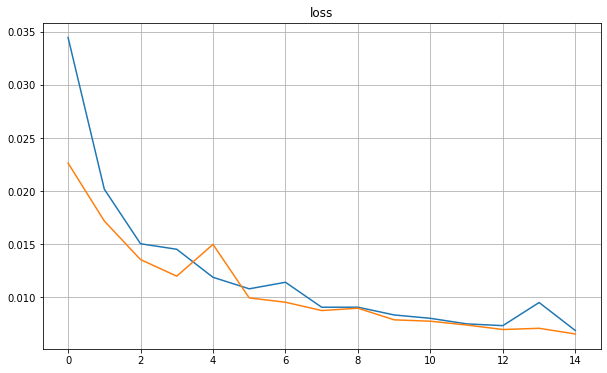

In [19]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

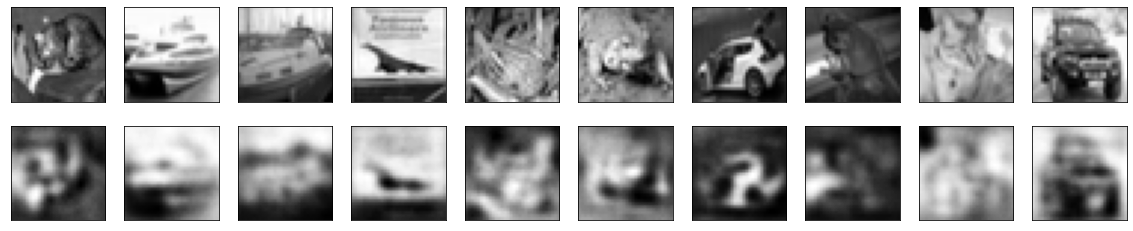

In [20]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs])

Results:

- Shallow Linear Autoencoder: 0.00567
- Shallow Non-Linear Autoencoder: 0.00652

First I used tanh non-linear function after that I changed my activation function with sigmoid and the results was better than previous values.

- tanh: 0.02411
- sigmoid: 0.00652

And also linear activation functions learns better in non-complex circumstances. In addition to that we have only one hidden layer. This is another advantage for linear functions because in complex situations we need at least 3 hidden layer and non-linear activation functions to get better results with non-linear models autoencoders.
The main reason why the results of linear and non-linear models are close is that there is only one encoded layer and one decoded layer.

We are gonna see the differences in the below example(Exercise 4). This should enable the network to achieve a wide range of neuron output values in the output and bottleneck layers. It effected when I change the epoch size but it takes too much time therefore I just wait until 15 epoch. When I wait up to 100 epochs the result was smaller than example 3 in 4. 
- The result after 100 epoch in Exercise 4  : ~0.00420

## Exercise 4: Deep Autoencoder
**Challange:** 

Build a deep version of the Autoencoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and $n-1$ for decoding. The layers sizes of the encoding part decrease at each layer (e.g., `INPUT_DIM->128->64`, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (e.g., `128->INPUT_DIM`, the final overall structure recalls an hourglass ⏳).
As usual, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


In [28]:
INPUT_DIM = x_train.shape[-1]
ENCODING_DIM = 64


input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
encoded_1 = tf.keras.layers.Dense(128, activation='sigmoid')(input_img)
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='tanh')(encoded_1)

decoded_1 = tf.keras.layers.Dense(128, activation='tanh')(encoded)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(decoded_1)

autoencoder = tf.keras.models.Model(input_img, decoded) 

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

In [29]:
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_8 (Dense)             (None, 128)               131200    
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                                                 
 dense_11 (Dense)            (None, 1024)              132096    
                                                                 
Total params: 279,872
Trainable params: 279,872
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = autoencoder.fit(x_train, x_train, epochs= 15, batch_size= 512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
79/79 [==============================] - 3s 28ms/step - loss: 0.0322 - val_loss: 0.0233
Epoch 2/15
79/79 [==============================] - 2s 27ms/step - loss: 0.0208 - val_loss: 0.0184
Epoch 3/15
79/79 [==============================] - 2s 26ms/step - loss: 0.0189 - val_loss: 0.0171
Epoch 4/15
79/79 [==============================] - 2s 26ms/step - loss: 0.0157 - val_loss: 0.0149
Epoch 5/15
79/79 [==============================] - 2s 27ms/step - loss: 0.0148 - val_loss: 0.0150
Epoch 6/15
79/79 [==============================] - 2s 26ms/step - loss: 0.0136 - val_loss: 0.0132
Epoch 7/15
79/79 [==============================] - 2s 26ms/step - loss: 0.0132 - val_loss: 0.0130
Epoch 8/15
79/79 [==============================] - 2s 27ms/step - loss: 0.0128 - val_loss: 0.0146
Epoch 9/15
79/79 [==============================] - 2s 27ms/step - loss: 0.0121 - val_loss: 0.0121
Epoch 10/15
79/79 [==============================] - 2s 26ms/step - loss: 0.0122 - val_loss: 0.0116
Epoch 11/

313/313 - 1s - loss: 0.0102 - 629ms/epoch - 2ms/step
test mse: 0.01020


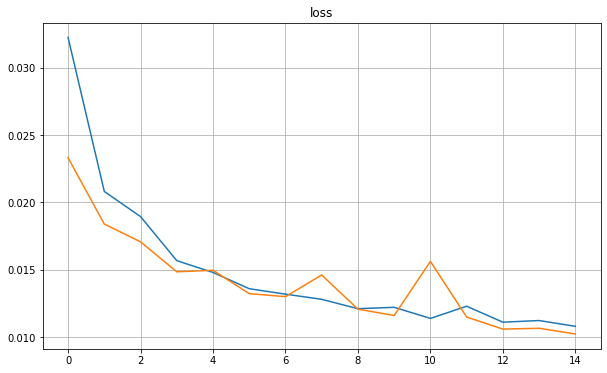

In [31]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

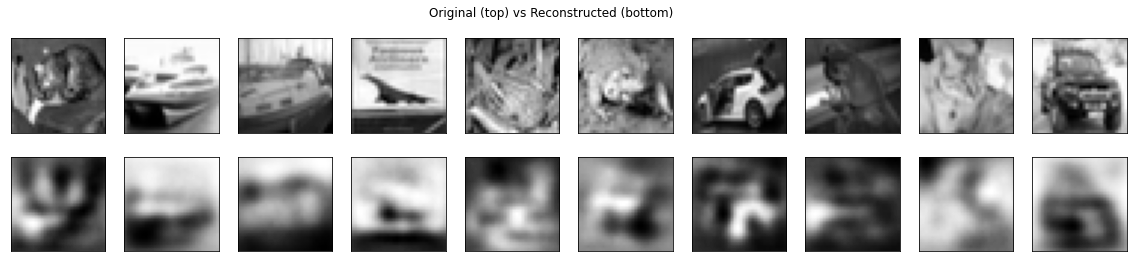

In [32]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

## Exercise 5: Denoising Autoencoder
**Challange:**

Let's now use a shallow autoencoder to denoise the input data. The idea is that only meaningful information will be encoded, thus filtering out useless noise.
Firstly, define a noisy input by adding some gaussian noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.

In [33]:
noise_factor = 0.3

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)

# we still have to be sure that the color values are in the [0,1] range:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs:

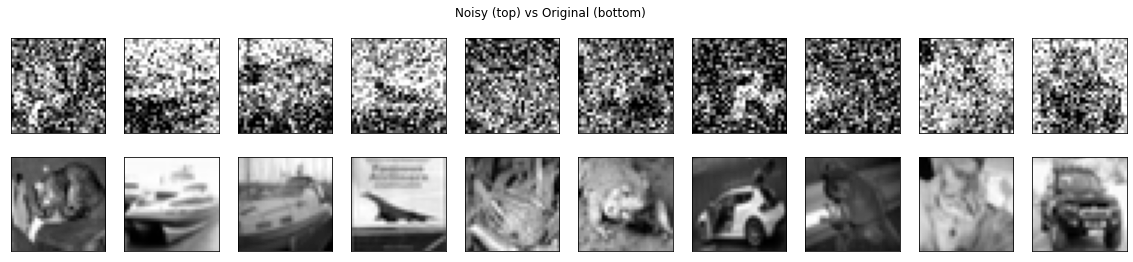

In [34]:
plot_img(10, [x_test_noisy, x_test], title = "Noisy (top) vs Original (bottom)")

**Define a shallow autoencoder able to compute a de-noised version of the input (use a noise_factor $\geq 0.3$).** 

In [35]:
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
 #[TO COMPLETE]
encoded = tf.keras.layers.Dense(256, activation='sigmoid')(input_img) 
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)

autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse') #[TO COMPLETE]

In [36]:
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_12 (Dense)            (None, 256)               262400    
                                                                 
 dense_13 (Dense)            (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


**Train the model by passing the noisy input and the clean target.** 

In [37]:
history = autoencoder.fit(x_train_noisy, x_train, epochs=20, batch_size=512, shuffle=True, validation_data=(x_valid_noisy, x_valid)) #[TO COMPLETE]

Epoch 1/20
79/79 [==============================] - 4s 40ms/step - loss: 0.0371 - val_loss: 0.0277
Epoch 2/20
79/79 [==============================] - 3s 39ms/step - loss: 0.0227 - val_loss: 0.0202
Epoch 3/20
79/79 [==============================] - 3s 39ms/step - loss: 0.0182 - val_loss: 0.0225
Epoch 4/20
79/79 [==============================] - 3s 38ms/step - loss: 0.0167 - val_loss: 0.0166
Epoch 5/20
79/79 [==============================] - 3s 38ms/step - loss: 0.0155 - val_loss: 0.0149
Epoch 6/20
79/79 [==============================] - 3s 38ms/step - loss: 0.0143 - val_loss: 0.0177
Epoch 7/20
79/79 [==============================] - 3s 39ms/step - loss: 0.0139 - val_loss: 0.0142
Epoch 8/20
79/79 [==============================] - 3s 38ms/step - loss: 0.0131 - val_loss: 0.0128
Epoch 9/20
79/79 [==============================] - 3s 39ms/step - loss: 0.0128 - val_loss: 0.0130
Epoch 10/20
79/79 [==============================] - 3s 39ms/step - loss: 0.0127 - val_loss: 0.0122
Epoch 11/

313/313 - 1s - loss: 0.0116 - 793ms/epoch - 3ms/step
Test mse: 0.01157


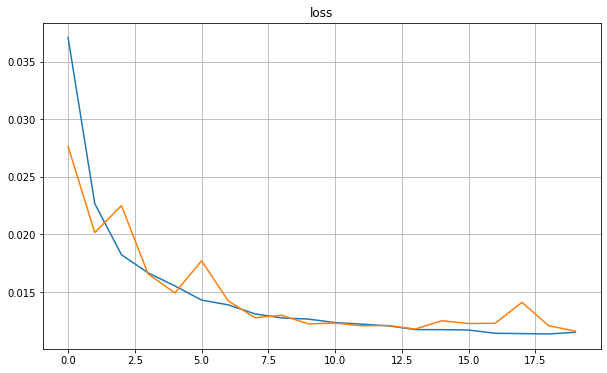

In [38]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

**Check the result by plotting some input images and the corresponding denoised outputs.** 

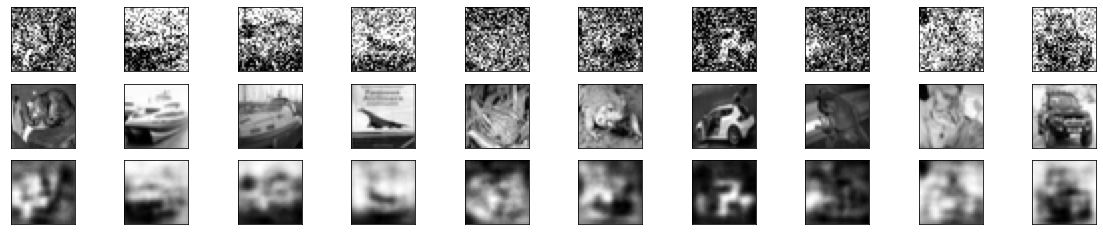

In [39]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, [x_test_noisy, x_test, decoded_imgs])

## Exercise 6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case we will use the IMDB dataset (already introduced in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in _Colab_), we will limit the number of training samples and test samples.

In [ ]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

1654784/1641221 [==============================] - 0s 0us/step


In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [ ]:
from tensorflow.keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)

Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 2, while the used encoding layer is defined by using `tf.keras.layers.SimpleRNN`. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 90, 100)]         0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 90, 50)            7550      
                                                                 
 time_distributed (TimeDistr  (None, 90, 100)          5100      
 ibuted)                                                         
                                                                 
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 7s 74ms/step - loss: 0.1720 - categorical_accuracy: 0.1896 - val_loss: 0.0803 - val_categorical_accuracy: 0.3896
Epoch 2/50
79/79 [==============================] - 6s 79ms/step - loss: 0.0779 - categorical_accuracy: 0.3678 - val_loss: 0.0708 - val_categorical_accuracy: 0.4114
Epoch 3/50
79/79 [==============================] - 5s 70ms/step - loss: 0.0629 - categorical_accuracy: 0.5099 - val_loss: 0.0600 - val_categorical_accuracy: 0.5296
Epoch 4/50
79/79 [==============================] - 6s 70ms/step - loss: 0.0577 - categorical_accuracy: 0.5397 - val_loss: 0.0556 - val_categorical_accuracy: 0.5501
Epoch 5/50
79/79 [==============================] - 5s 69ms/step - loss: 0.0525 - categorical_accuracy: 0.5697 - val_loss: 0.0509 - val_categorical_accuracy: 0.5878
Epoch 6/50
79/79 [==============================] - 5s 69ms/step - loss: 0.0475 - categorical_accuracy: 0.6043 - val_loss: 0.0460 - val_categorical_accuracy: 0.6012
Epoch 7/50

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 0s - loss: 0.0120 - categorical_accuracy: 0.9315 - 374ms/epoch - 9ms/step
categorical_accuracy: 93.15%


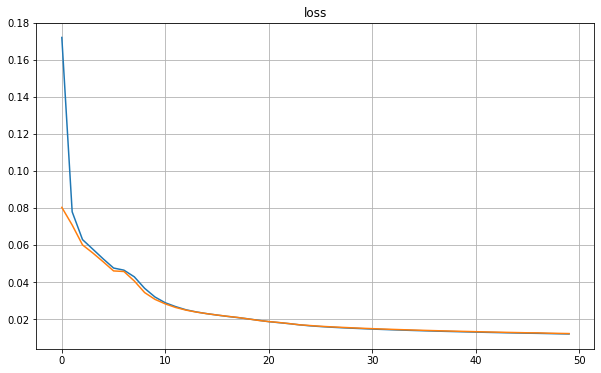

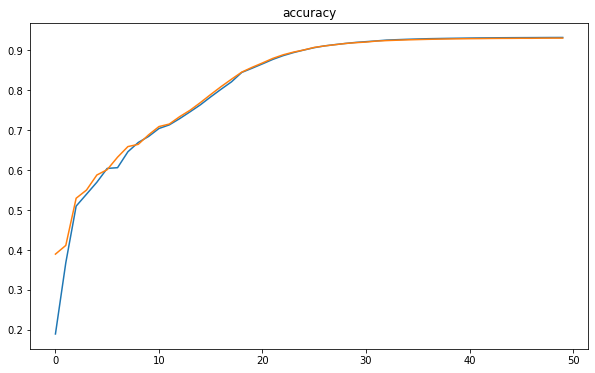

In [ ]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> <oov> are <oov> in all of are time but have <oov> the <oov> is <oov> a like <oov> film in just about <oov> <oov> <oov> <oov> as to the <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> to <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film first <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> to <oov>


## Exercise 7: Non-Linear Autoencoder for sequences
**Challange:**

Replicate the code of the above exercise, but instead of using a simple RNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, return_sequences=True, activation='tanh')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 90, 100)]         0         
                                                                 
 lstm (LSTM)                 (None, 90, 50)            30200     
                                                                 
 time_distributed_1 (TimeDis  (None, 90, 100)          5100      
 tributed)                                                       
                                                                 
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 6s 26ms/step - loss: 0.0430 - categorical_accuracy: 0.4435 - val_loss: 0.0371 - val_categorical_accuracy: 0.4636
Epoch 2/50
79/79 [==============================] - 1s 14ms/step - loss: 0.0357 - categorical_accuracy: 0.4737 - val_loss: 0.0349 - val_categorical_accuracy: 0.4657
Epoch 3/50
79/79 [==============================] - 1s 14ms/step - loss: 0.0326 - categorical_accuracy: 0.4809 - val_loss: 0.0305 - val_categorical_accuracy: 0.4921
Epoch 4/50
79/79 [==============================] - 1s 14ms/step - loss: 0.0279 - categorical_accuracy: 0.4989 - val_loss: 0.0259 - val_categorical_accuracy: 0.4928
Epoch 5/50
79/79 [==============================] - 1s 14ms/step - loss: 0.0234 - categorical_accuracy: 0.5573 - val_loss: 0.0216 - val_categorical_accuracy: 0.6404
Epoch 6/50
79/79 [==============================] - 1s 14ms/step - loss: 0.0192 - categorical_accuracy: 0.7198 - val_loss: 0.0174 - val_categorical_accuracy: 0.7493
Epoch 7/50

40/40 - 0s - loss: 2.4910e-05 - categorical_accuracy: 1.0000 - 220ms/epoch - 6ms/step
categorical_accuracy: 100.00%


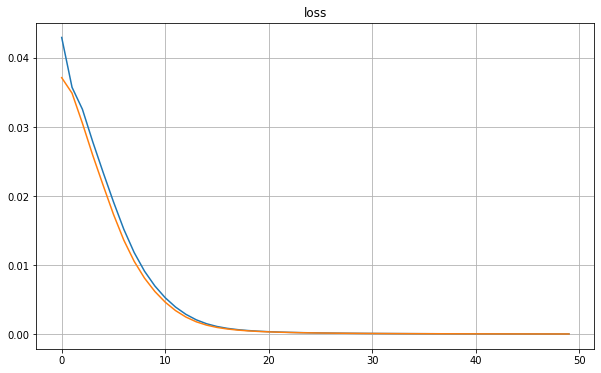

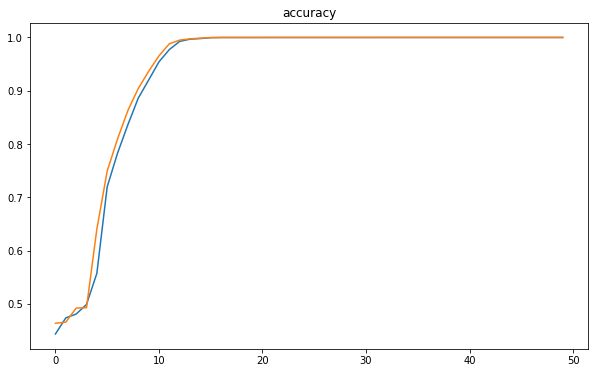

In [ ]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


**RESULTS**:

- Linear Autoencoder: loss: 0.0120, accuracy: 93.15%;
- Non-Linear Autoencoder (with tanh activation function): loss: 2.4910e-05, accuracy: 100%

The reason why the nonlinear autoencoder achieved better results than the linear autoencoder is the same explained for the shallow linear autoencoder and the shallow nonlinear autoencoder. Using a non-linear activation function allows you to detect more of the most important characteristics than a linear activation function. This is an advantage because the network is able to reconstruct the sentence with greater precision.

The reasons for not using sigmoid in previous layers is related to its computational cost and the vanishing gradients problem. At this points thanks to the structure of the LSTM. It helped prevent it.

One common problem is the compression vs conceptualization dilemma. Similar to the exploration vs exploitation dilemma, we want the autoencoder to conceptualize not compress, (i.e. learn feature representations), however, we “reward” (with MSE and SGD) perfect reconstruction of the data, which encourages compression rather than conceptualization. This has caused auto encoders to struggle for more “involved” tasks. Denoising auto encoders are an attempt to fix this problem by introducing random noise to the input and having the encoder try to remove the noise, therefore theoretically forcing the autoencoder to learn the feature representation.

Forward autoencoders work well for static inputs like individual images. You can only use them for sequential data by fixing the data size, usually by padding all sequences with zero vectors to the length of the longest sequence. In contrast, recurrent auto encoders can compress variable length sequences into fixed length representations.

Moreover, recurrent networks(e.g. LSTM) reuse their weight matrix for all time steps. Therefore, they can generalize dependencies between nearby frames to other positions in the sequence. A forward auto encoder(e.g. Simple RNN) would have to learn such a structure individually for each position in time.

